In [2]:
import sys, os
import numpy as np

sys.path.append(os.path.abspath('./'))
from pysplendor.game import Trajectory, traj_loader
from pysplendor.splendor import SplendorGameState, CARD_LEVELS, Action, CHANCE_PLAYER
from prepare_data import SplendorGameStateEncoder, ACTION_ID
import matplotlib.pyplot as plt

In [4]:
traj_file = os.path.abspath('./data/traj_dump_1k.txt')
state_encoder = SplendorGameStateEncoder(2)
STATE_LEN = 1052
NUM_ACTIONS = 43

state_bit_counts = np.zeros(shape=(STATE_LEN,))
action_counts = [0] * NUM_ACTIONS

num_states = 0
for traj in traj_loader(traj_file):
    state = traj.initial_state.copy()
    for action in traj.actions:
        if state.active_player() != CHANCE_PLAYER: # ignore chance nodes
            state_vec = state_encoder.state_to_vec(state)
            state_bit_counts += np.array(state_vec)
            num_states += 1
            action_counts[ACTION_ID.get(str(action))] += 1

        state.apply_action(action)


In [5]:
print(f'num states: {num_states}')
print(f'sum action counts: {sum(action_counts)}')
for action, n in ACTION_ID.items():
    print(f'{action}: {action_counts[n]} {action_counts[n] / num_states * 100:.2f}%')

probs = [action_counts[n] / num_states for n in range(len(ACTION_ID))]
print(','.join([f'{p:.4f}' for p in probs]))

num states: 63096
sum action counts: 63096
s: 4046 6.41%
tr2: 853 1.35%
tg2: 912 1.45%
tb2: 925 1.47%
tw2: 900 1.43%
tk2: 884 1.40%
tr1g1b1: 2368 3.75%
tr1g1w1: 2128 3.37%
tr1g1k1: 2153 3.41%
tr1b1w1: 2144 3.40%
tr1b1k1: 2053 3.25%
tr1w1k1: 2084 3.30%
tg1b1w1: 2120 3.36%
tg1b1k1: 2015 3.19%
tg1w1k1: 1960 3.11%
tb1w1k1: 2122 3.36%
r0n0: 82 0.13%
r0n1: 39 0.06%
r0n2: 31 0.05%
r0n3: 42 0.07%
r1n0: 169 0.27%
r1n1: 176 0.28%
r1n2: 158 0.25%
r1n3: 167 0.26%
r2n0: 1645 2.61%
r2n1: 1589 2.52%
r2n2: 1509 2.39%
r2n3: 1523 2.41%
p0n0: 3939 6.24%
p0n1: 3956 6.27%
p0n2: 4229 6.70%
p0n3: 5191 8.23%
p1n0: 1295 2.05%
p1n1: 1230 1.95%
p1n2: 1462 2.32%
p1n3: 1746 2.77%
p2n0: 332 0.53%
p2n1: 340 0.54%
p2n2: 373 0.59%
p2n3: 400 0.63%
h0: 681 1.08%
h1: 629 1.00%
h2: 496 0.79%
0.0641,0.0135,0.0145,0.0147,0.0143,0.0140,0.0375,0.0337,0.0341,0.0340,0.0325,0.0330,0.0336,0.0319,0.0311,0.0336,0.0013,0.0006,0.0005,0.0007,0.0027,0.0028,0.0025,0.0026,0.0261,0.0252,0.0239,0.0241,0.0624,0.0627,0.0670,0.0823,0.0205,0.0

In [6]:
num_nonzero = sum([1 for x in state_bit_counts if x > 0])
print(f'nonzero bits: {num_nonzero} of {STATE_LEN}')
print('percentage of 1-s in each state position')
for n, freq in enumerate(state_bit_counts):
    if freq > 0:
        print(f'{n}: {freq / num_states * 100:.2f}%')
# print(state_bit_counts)

nonzero bits: 827 of 1052
percentage of 1-s in each state position
0: 49.18%
3: 29.58%
4: 21.10%
5: 49.94%
8: 30.33%
9: 19.59%
10: 51.20%
13: 30.53%
14: 18.14%
15: 50.88%
18: 29.13%
19: 19.85%
20: 48.51%
23: 30.05%
24: 21.31%
25: 99.87%
30: 49.00%
33: 30.63%
34: 19.45%
35: 48.65%
38: 29.13%
39: 21.30%
40: 49.67%
43: 28.97%
44: 20.44%
45: 50.29%
48: 29.82%
49: 18.97%
50: 50.02%
53: 30.26%
54: 18.80%
55: 99.08%
60: 49.16%
63: 26.59%
64: 19.56%
65: 47.67%
68: 27.03%
69: 20.60%
70: 48.51%
73: 28.36%
74: 18.44%
75: 45.40%
78: 31.37%
79: 18.54%
80: 47.75%
83: 28.95%
84: 18.61%
85: 95.31%
90: 20.47%
91: 21.32%
92: 19.06%
93: 20.91%
94: 18.24%
96: 79.91%
97: 20.09%
102: 53.62%
103: 22.84%
104: 13.95%
105: 5.41%
106: 4.18%
107: 54.96%
108: 23.46%
109: 13.16%
110: 4.93%
111: 3.49%
112: 53.06%
113: 23.55%
114: 13.41%
115: 6.50%
116: 3.49%
117: 52.35%
118: 22.98%
119: 13.63%
120: 6.58%
121: 4.46%
122: 52.77%
123: 24.11%
124: 13.61%
125: 5.04%
126: 4.48%
127: 100.00%
132: 19.70%
133: 20.26%
134: 19

In [ ]:
# look at model predictions for a particular trajectory
import torch
from train import TwoHeadMLP
from prepare_data import SplendorGameStateEncoder, ALL_ACTIONS

def model_predict(model, state_encoder, state, K=5):
    '''Retruns top K predicted actions and qvalue'''
    state_vec = state_encoder.state_to_vec(state)
    X = torch.tensor(state_vec, dtype=torch.float32)
    logits, qval = model.forward(X)
    top_actions = np.argsort(logits.detach().numpy())[-K:]
    logits = logits[top_actions]
    return top_actions, logits, qval.item()

def run_model():
    '''Aloows to inspect the moves predicted by the model'''
    state_encoder = SplendorGameStateEncoder(2)
    STATE_LEN = 1052
    NUM_ACTIONS = 43

    model = TwoHeadMLP(STATE_LEN, 50, NUM_ACTIONS)
    model_path = './data/models/mlp_0.pth'
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()

    traj_file = './data/traj_dump_10k.txt'
    loader = traj_loader(traj_file)
    for _ in range(1100):
        next(loader)
    traj = next(loader) # pick one
    state = traj.initial_state.copy()
    rewards = traj.rewards

    for action in traj.actions:
        if state.active_player() != CHANCE_PLAYER: # ignore chance nodes
            top_actions, logits, qval = model_predict(model, state_encoder, state, K=5)
            print(state)
            suggested_actions = ' '.join([f'{ALL_ACTIONS[a]} ({l:.2f})' for a, l in zip(top_actions, logits)])
            print(f'predicted actions: {suggested_actions} qval: {qval:.3f} reward: {rewards[state.active_player()]}')
            print(f'actual action: {action}\n')

        state.apply_action(action)

run_model()

Traceback (most recent call last):
  File "/Users/seal/.vscode/extensions/ms-python.python-2025.2.0-darwin-arm64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 7, in <module>
  File "/opt/homebrew/lib/python3.10/site-packages/torch/serialization.py", line 1471, in load
    return _load(
  File "/opt/homebrew/lib/python3.10/site-packages/torch/serialization.py", line 1964, in _load
    result = unpickler.load()
  File "/opt/homebrew/lib/python3.10/site-packages/torch/serialization.py", line 1953, in find_class
    return super().find_class(mod_name, name)
AttributeError: Can't get attribute 'TwoHeadMLP' on <module '__main__' from '/Users/seal/.vscode/extensions/ms-python.python-2025.2.0-darwin-arm64/python_files/python_server.py'>



In [ ]:
from pysplendor.agents import MCTSAgent, MCTS
# from prepare_data import ACTION_ID

def print_root_visits(mcts: MCTS):
    children_dict = {str(child.action): child for child in mcts.root.children}
    for action in ALL_ACTIONS:
        if action in children_dict:
            child = children_dict[action]
            print(f'{child.action}:\t{child.visits}')

    # children = sorted(mcts.root.children, key=lambda x: x.visits)
    # for child in children:
    #     print(f'{child.action}: {child.visits}')

def compare_mcts_variants():
    traj_file = './data/traj_dump.txt'
    loader = traj_loader(traj_file)
    # for _ in range(1100):
    #     next(loader)
    traj = next(loader) # pick one
    state = traj.initial_state.copy()
    rewards = traj.rewards

    for action in traj.actions:
        if state.active_player() != CHANCE_PLAYER: # ignore chance nodes
            print(state)
            agent1 = MCTS(state)
            agent2 = MCTS(state)

            action1 = agent1.search()
            action2 = agent2.search()

            print(f'action1: {action1} action2: {action2} actual action: {action}\n')
            print('\nagent1:')
            print_root_visits(agent1)
            print('\nagent2:')
            print_root_visits(agent2)

        state.apply_action(action)




Traceback (most recent call last):
  File "/Users/seal/.vscode/extensions/ms-python.python-2025.2.0-darwin-arm64/python_files/python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 1, in <module>
  File "/Users/seal/projects/splendor/pysplendor/agents.py", line 5, in <module>
    from .mcts import MCTS
  File "/Users/seal/projects/splendor/pysplendor/mcts.py", line 5, in <module>
    from .game_state import GameState, CHANCE_PLAYER
ImportError: cannot import name 'CHANCE_PLAYER' from 'pysplendor.game_state' (/Users/seal/projects/splendor/pysplendor/game_state.py)



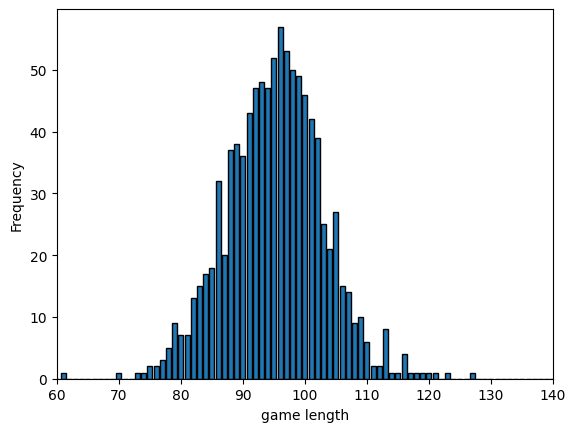

In [3]:
traj_file = os.path.abspath('./data/traj_dump_1k.txt')

max_len = 150
game_lens = [0] * max_len
for traj in traj_loader(traj_file):
    game_lens[len(traj.actions)] += 1

plt.bar(range(max_len), game_lens, edgecolor='black')

plt.xlabel('game length')
plt.ylabel('Frequency')
plt.xlim(60, 140)
plt.show()


